In [1]:
!python --version # should say 3.7.16

Python 3.7.16


In [2]:
import os
from agent import Agent
from helper_scripts import evaluate_agents, baseline, create_agents, plot_losses
os.chdir("..")
from rice import Rice

import torch
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from typing import List

/home/ivaylo/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
env = Rice(region_yamls_filename='fewer_region_yamls')
env.num_agents

4

In [4]:
agents = create_agents(env)

In [5]:
# Adapted from https://huggingface.co/deep-rl-course/unit4/hands-on?fw=pt
def reinforce(agents : List[Agent], 
              n_training_episodes : int, 
              gamma : float) -> None:
    
    optimizers = [torch.optim.Adam(agent.nets[0].parameters(), lr=.001) for agent in agents]
    
    losses = [[] for agent in agents]
    
    for i_episode in tqdm(range(1, n_training_episodes+1)):
        saved_log_probs = [[] for agent in agents]
        rewards = [[] for agent in agents]
        state = env.reset()
        assert env.timestep == 0
        
        # Generate a whole episode
        for t in range(env.episode_length):
            collective_action = {}
            for agent in agents:
                action, log_prob = agent.act(0, state[agent.id])
                saved_log_probs[agent.id].append(log_prob)
                collective_action[agent.id] = np.array(action)
                
            state, reward, done, _ = env.step(collective_action)
            
            for agent in agents:
                rewards[agent.id].append(reward[agent.id])
        
        returns = [deque(maxlen=env.episode_length) for agent in agents] 
        
        # Calculate discounted returns
        for t in range(env.episode_length)[::-1]:
            for agent in agents:
                disc_return_t = (returns[agent.id][0] if len(returns[agent.id])>0 else 0)
                returns[agent.id].appendleft( gamma*disc_return_t + rewards[agent.id][t]   )    
            
        eps = np.finfo(np.float32).eps.item()
        
        # Standardize returns
        returns = [torch.tensor(returns[agent.id]) for agent in agents]
        for agent in agents:
            returns[agent.id] = (returns[agent.id] - returns[agent.id].mean()) / (returns[agent.id].std() + eps)

        # Calculate loss and update weights
        policy_loss = [[] for agent in agents]
        for agent in agents:
            for log_prob, disc_return in zip(saved_log_probs[agent.id], returns[agent.id]):
                policy_loss[agent.id].append(-log_prob * disc_return)
            loss = torch.cat(policy_loss[agent.id]).sum()
            losses[agent.id].append(loss.item())
            
            optimizers[agent.id].zero_grad()
            loss.backward()
            optimizers[agent.id].step()
    return losses

In [6]:
losses = reinforce(agents, n_training_episodes = 100, gamma = .9)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.44it/s]


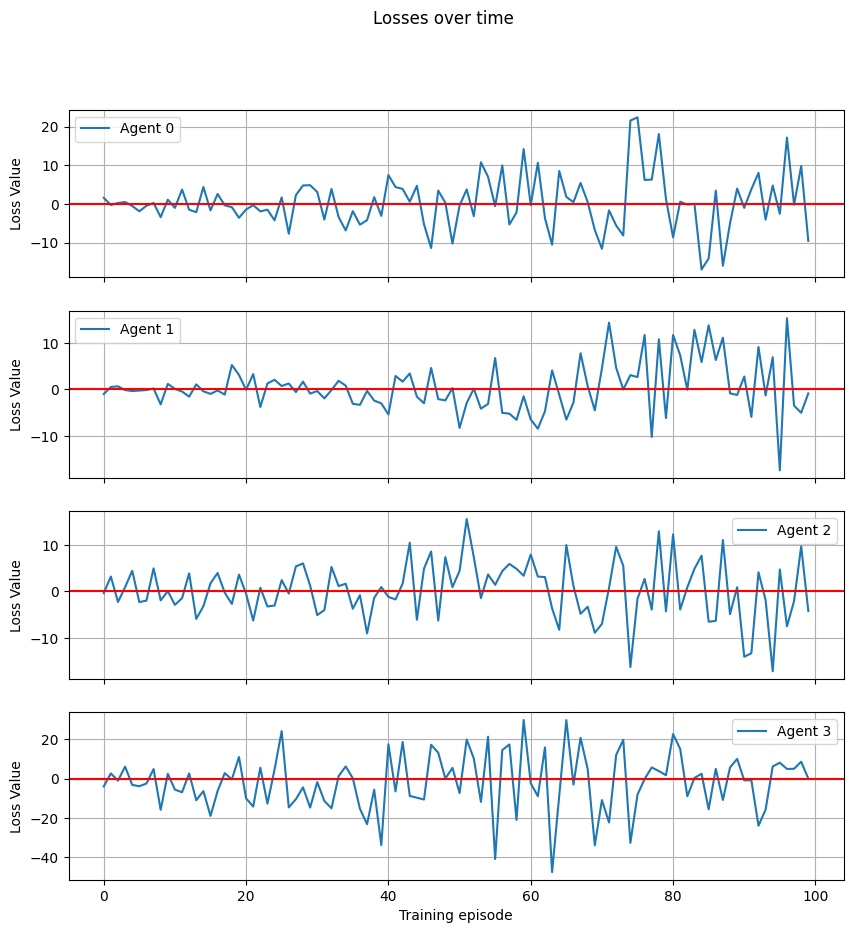

In [7]:
plot_losses(losses)

In [13]:
def evaluate_agents(agents : List[Agent]) -> dict:
    state = env.reset()
    collective_actions = []
    all_rewards = [[] for agent in agents]
    for i in range(env.episode_length):
        collective_action = {}
        for agent in agents:
            action, _ = agent.act(0, state[agent.id])
            collective_action[agent.id] = np.array(action)
        state, reward, done, _ = env.step(collective_action)
        
        for agent in agents:
            all_rewards[agent.id].append(reward[agent.id])
        
        collective_actions.append(collective_action)
    return env.global_state, collective_actions, all_rewards

In [14]:
def baseline() -> dict:
    return evaluate_agents(create_agents())

In [15]:
state, actions, rewards = evaluate_agents(agents)

In [16]:
state_base, actions_base, rewards_base = baseline()

In [17]:
[list(zip(l1, l2)) for (l1, l2) in zip(rewards, rewards_base)]

[[(0.12218706, 0.07982088),
  (0.0011548965, 0.052464433),
  (0.0005267963, 0.12717679),
  (0.0018808318, 0.0011397871),
  (0.15072884, 0.36697957),
  (0.15473257, 0.25830773),
  (0.12466049, 0.17796849),
  (0.1472598, 0.0014390163),
  (0.20938456, 0.3421902),
  (0.0028837246, 0.0015634418),
  (0.23805133, 0.15738007),
  (0.18711437, 0.21520714),
  (0.0020519965, 0.006056347),
  (0.29815194, 0.40412974),
  (0.32848933, 0.3578844),
  (0.0030866207, 0.22041737),
  (0.0030977267, 0.0032982845),
  (0.003692702, 0.10284259),
  (0.3728145, 0.37036043),
  (0.09611582, 0.17324576)],
 [(0.08897451, 0.0023806442),
  (0.07554349, 0.08198208),
  (0.077438846, 0.09242852),
  (0.09926608, 0.09607575),
  (0.10637756, 0.07674149),
  (0.07590576, 0.10560055),
  (0.0019460781, 0.10670972),
  (0.002237386, -0.0),
  (0.063045256, 0.09225173),
  (0.0034721456, 5.1481447e-08),
  (0.0615541, 0.12267575),
  (0.06458692, 0.00069680845),
  (0.0033565788, 0.09933133),
  (0.005656402, 0.11181759),
  (0.08878824, 

The functions below I used when there was negotiation enabled. Right now they are not relevant.

In [5]:
def get_features_n() -> int:
    """
    Take the number features from the observation that are relevant for the actions. (and not for the negotiation)
    """
    return sum(np.prod(env.global_state[feature]['value'].shape[1:]) 
               for feature in 
               env.global_features + env.public_features) + env.num_regions + len(env.private_features)

features_n = get_features_n()
features_n

77

In [8]:
def trim_observation(state : dict, agent_id : int):
    """
    Slice the observation such that it includes features only relevant for taking actions
    """
    observation = state[agent_id].copy()
    observation['features'] = observation['features'][:features_n]
    observation['action_mask'] = observation['action_mask'][:actions_n]
    return observation

def get_observation_space(agent_id : int):
    """
    Get the observation space that is relevant for taking actions
    """
    observation = trim_observation(initial_state, agent_id)
    return recursive_obs_dict_to_spaces_dict(observation)

def get_action_space(agent_id : int):
    """
    Get the action space that is relevant for takin actions
    """
    return env.action_space[agent_id][:action_spaces_n]
    

In [6]:
def get_action_spaces_n() -> int:
    """
    Take the number of action spaces that are relevant for the actions. (and not for the negotiation)
    """
    return len(env.savings_action_nvec + env.mitigation_rate_action_nvec + 
              env.export_action_nvec + env.import_actions_nvec + env.tariff_actions_nvec)

action_spaces_n = get_action_spaces_n()
action_spaces_n

11

In [7]:
def get_actions_n(agent_id : int) -> int:
    """
    Take the total number of actions in the relevant action spaces.
    """
    return sum(space.n for space in env.action_space[agent_id][:action_spaces_n])

actions_n = get_actions_n(agent_id = 0)
actions_n

110